In [4]:
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp

from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

## Obtaining grid

In [7]:
def generate_gp_data(l=30, train_size=20, test_size=10, noise_std=0.01, seed=None):
    """
    Generates training and test datasets for Gaussian Process regression using PyTorch.

    Args:
        l (int, optional): Total number of grid points. Defaults to 30.
        train_size (int, optional): Number of training points. Defaults to 20.
        test_size (int, optional): Number of test points. Defaults to 10.
        noise_std (float, optional): Standard deviation of Gaussian noise. Defaults to 0.01.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        tuple:
            - X_train (torch.Tensor): Training input points of shape (train_size,).
            - y_train (torch.Tensor): Training observations with noise of shape (train_size,).
            - X_test (torch.Tensor): Test input points of shape (test_size,).
            - y_test (torch.Tensor): Test observations with noise of shape (test_size,).
    """
    # Set random seed for reproducibility if provided
    if seed is not None:
        torch.manual_seed(seed)
    
    # Define the function g(x)
    def g(x):
        return -(torch.sin(6 * torch.pi * x)**2) + 6 * (x**2) - 5 * (x**4) + 1.5

    # Create a grid of points in [0, 1]
    xx = torch.linspace(0, 1, steps=l)
    
    # Shuffle the grid using a random permutation
    perm = torch.randperm(l)
    xx = xx[perm]
    
    # Split into training and test sets
    X_train = xx[:train_size]
    X_test = xx[train_size:train_size + test_size]
    
    # Generate noisy observations for training and testing
    y_train = g(X_train) + torch.normal(mean=0.0, std=noise_std, size=(train_size,))
    y_test = g(X_test) + torch.normal(mean=0.0, std=noise_std, size=(test_size,))
    
    return X_train, y_train, X_test, y_test


In [9]:
X, y, x_test, y_test = generate_gp_data()

## Gaussian proccess 

In [27]:
alpha = pyro.sample("alpha", dist.LogNormal(0.0, 1.0))
lengthscale = pyro.sample("lengthscale", dist.LogNormal(0.0, 1.0))
noise = torch.tensor(0.01)


# Construct GP
# (lternatively, use gp.models.GPRegression directly)
kernel = gp.kernels.RBF(input_dim=1, variance=alpha**2, lengthscale=lengthscale)
gpr = gp.models.GPRegression(X, y, kernel, noise = noise )

In [29]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)

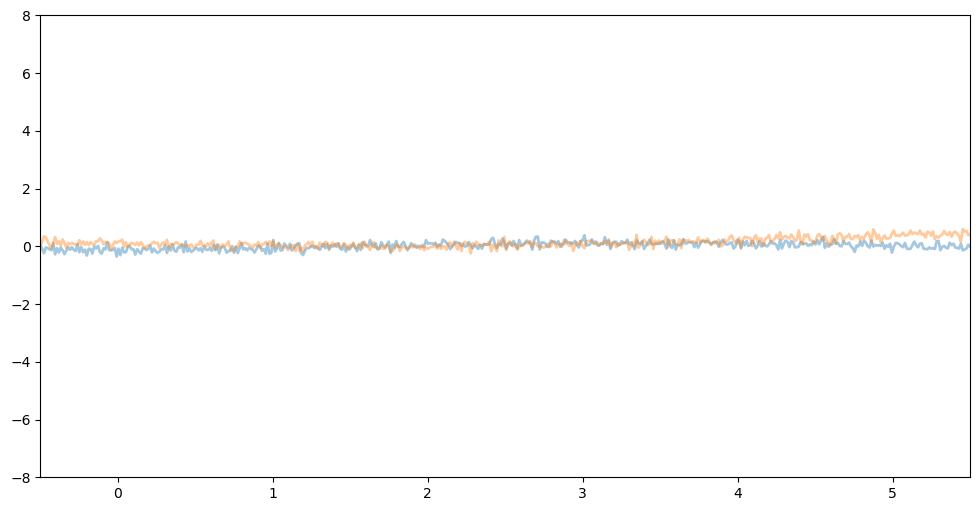

In [31]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-8, 8))

## MAP

In [34]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(2.0)
)
gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(0.01))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000 
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

In [36]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

variance = 1.3343054056167603
lengthscale = 0.4501625895500183
noise = 0.11578503996133804


In [255]:
fitted_kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.22), lengthscale=torch.tensor(0.58))

## Nuts sampling

In [ ]:
!pip install --upgrade arviz

In [38]:
import arviz as az


In [40]:
pyro.clear_param_store()
def model(X, y):
    kernel = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(2.0)
    )
    gpr = gp.models.GPRegression(X, y, kernel, noise = torch.tensor(0.01))
    
    # note that our priors have support on the positive reals
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.model()

In [75]:
# Hyperparameters for sampling
num_samples = 1000      # total posterior samples
warmup_steps = 100      # "burn-in" period
num_chains = 2          # number of parallel MCMC chains

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=num_chains)

mcmc.run(X, y)





Warmup [1]:   0%|          | 0/1100 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1100 [00:00, ?it/s]

/home/alex5848/anaconda3/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<Axes: title={'center': 'kernel.lengthscale'}>,
       <Axes: title={'center': 'kernel.variance'}>], dtype=object)

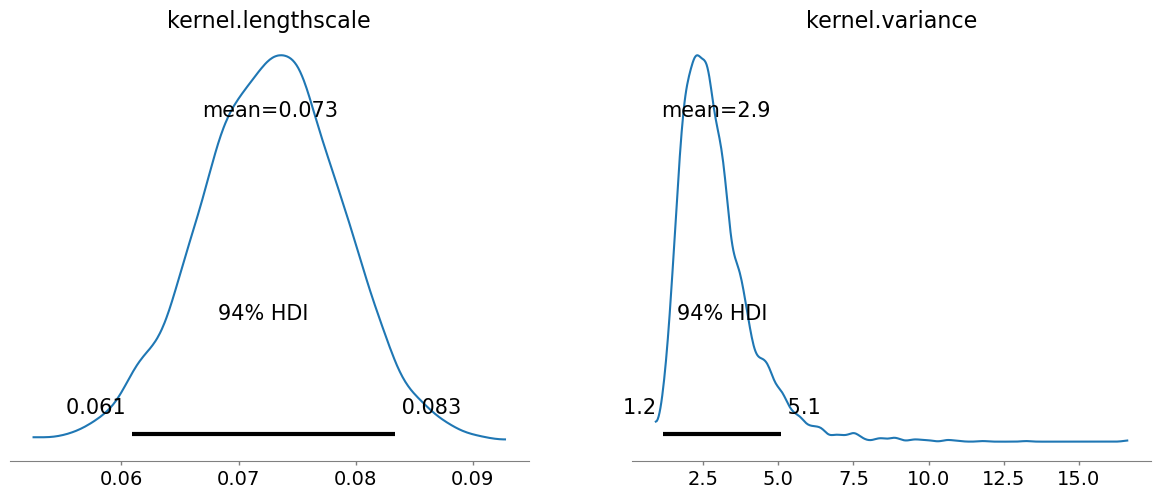

In [65]:
sample_data = az.from_pyro(mcmc)
sample_summary = az.summary(sample_data)

az.plot_posterior(sample_data)

array([[<Axes: title={'center': 'kernel.lengthscale'}>,
        <Axes: title={'center': 'kernel.lengthscale'}>],
       [<Axes: title={'center': 'kernel.variance'}>,
        <Axes: title={'center': 'kernel.variance'}>]], dtype=object)

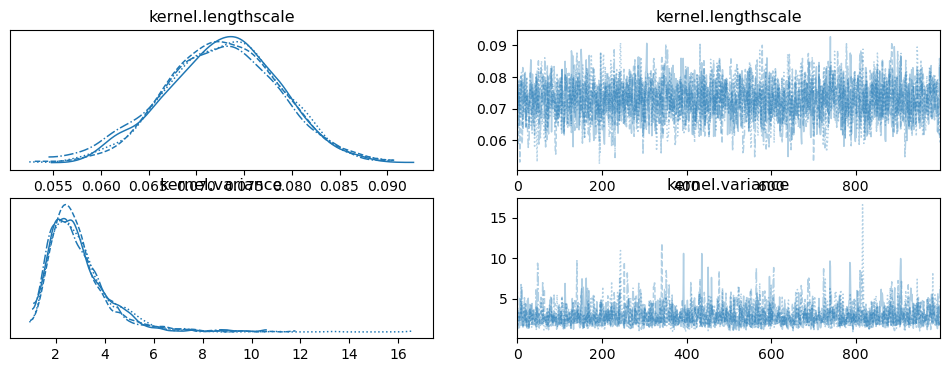

In [70]:
az.plot_trace(sample_data)

In [73]:
print(sample_summary)

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.073  0.006   0.061    0.083       0.00    0.000   
kernel.variance     2.930  1.267   1.151    5.093       0.03    0.022   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale    2067.0    1970.0    1.0  
kernel.variance       1961.0    2116.0    1.0  
